## Motivation and scope

This notebook presents an exploratory Bayesian re-analysis of non-photochemical quenching (NPQ) correction using in situ fluorescence data from Lake George. The goal is not to propose a finalized operational algorithm, but rather to demonstrate how hierarchical Bayesian modeling can be used to (i) represent uncertainty in NPQ correction explicitly, (ii) borrow strength across sites via partial pooling, and (iii) separate uncertainty in the learned light–response relationship from observation-level variability.

The analysis is intended as a methodological demonstration and collaboration hook, rather than a definitive replacement for existing correction schemes. In particular, we emphasize interpretability, uncertainty quantification, and alignment with a causal understanding of the NPQ process.


In [ ]:
from pathlib import Path
import re
import pandas as pd
import numpy as np
from patsy import dmatrix
import pymc as pm
import arviz as az
import matplotlib as mpl

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


In [ ]:
# SET PATHS
PROJECT_PATH = Path.cwd().parent
ARTIFACTS_PATH = PROJECT_PATH / 'artifacts'
DATA_PATH = PROJECT_PATH / 'data'
FIG_PATH = PROJECT_PATH / "figures"
PROCESSED_DATA_PATH = DATA_PATH / 'processed'

In [ ]:
# HELPER FUNCTIONS

# A. File I/O Helpers
# --- 1) Filename helper ---
def _slug(name: str) -> str:
    s = name.strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

# --- 2) Matplotlib save (consistent across notebook/blog) ---
def save_mpl(fig, name: str, *, dpi=200):
    """
    Saves matplotlib figure as PNG with consistent margins/background.
    Does NOT change how the figure looks when displayed in the notebook.
    """
    path = FIG_PATH / f"{_slug(name)}.png"

    # Ensure consistent text rendering; doesn't change appearance unless you were relying on defaults.
    # If you already set these elsewhere, you can remove them.
    mpl.rcParams["savefig.facecolor"] = "white"
    mpl.rcParams["savefig.edgecolor"] = "white"

    fig.savefig(
        path,
        dpi=dpi,
        facecolor="white",
        edgecolor="white",
        bbox_inches="tight",
        pad_inches=0.05,
    )
    return path

# --- 3) Plotly save: interactive HTML (kept small via CDN JS) ---
def save_plotly_html(fig, name: str, *, include_plotlyjs="cdn"):
    """
    Saves Plotly interactive figure as HTML.
    include_plotlyjs="cdn" keeps the file light (needs internet to load plotly JS).
    """
    path = FIG_PATH / f"{_slug(name)}.html"
    fig.write_html(
        str(path),
        include_plotlyjs=include_plotlyjs,
        full_html=True,
        config={"displaylogo": False, "responsive": True},
    )
    return path

# --- 4) Optional: Plotly PNG (only if you want a static fallback/thumbnail) ---
def save_plotly_png(fig, name: str, *, width=1100, height=650, scale=2):
    """
    Requires kaleido. Use only for a static backup PNG.
    """
    path = FIG_PATH / f"{_slug(name)}.png"
    fig.write_image(str(path), width=width, height=height, scale=scale)
    return path

# B. Plotting helpers
# --- 1) RGBA color helper ---
def rgba(hex_color: str, alpha: float) -> str:
    hex_color = hex_color.lstrip("#")
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return f"rgba({r},{g},{b},{alpha})"

# --- 2) Stack samples ---
def stack_sample(da):
    if "chain" in da.dims and "draw" in da.dims:
        return da.stack(sample=("chain", "draw"))
    if "sample" in da.dims:
        return da
    raise ValueError(f"Unexpected dims: {da.dims}")

# --- 3) Quantile summary ---
def q_summary(x, lo=0.03, hi=0.97, axis=0):
    return (
        np.quantile(x, lo, axis=axis),
        np.median(x, axis=axis),
        np.quantile(x, hi, axis=axis),
    )

## Recall what is going on conceptually

The NPQ correction problem can be understood as a sequence of linked physical and biological processes, only some of which are directly observed.

* **Sun–geometry–weather → irradiance.**  
  Solar geometry (e.g., solar azimuth, time of day, season) and atmospheric conditions (e.g., clouds) determine surface irradiance. This surface signal is then transformed by water optical properties and depth into subsurface irradiance, which is the relevant driver of photophysiological response.

* **Irradiance & physiology → NPQ state.**  
  Subsurface irradiance, recent light history, and water temperature (together with unobserved physiological state) determine the degree of non-photochemical quenching (NPQ). NPQ is treated as a latent physiological state that responds nonlinearly to light.

* **Chlorophyll & NPQ → measured fluorescence.**  
  A latent true chlorophyll concentration (Chla_true) emits fluorescence, but the observed fluorescence signal (Fchl) is suppressed by the NPQ state and further affected by sensor-specific and environmental factors. NPQ therefore acts as a multiplicative (or yield-reducing) process on fluorescence rather than a direct proxy for biomass.

* **Reference fluorescence as a low-NPQ proxy.**  
  The reference fluorescence (Fchl_Reference), derived from dark-adapted conditions or algorithmic approximations, is assumed to correspond to a low-NPQ regime and is therefore closer to Chla_true than instantaneous daytime fluorescence.

* **Dissolved oxygen saturation (DO_sat) as a downstream proxy.**  
  DO_sat is influenced by primary productivity and therefore depends on Chla_true, irradiance, temperature, and physical mixing. While potentially useful for prediction, DO_sat is a descendant of several upstream processes and may act as a collider if included in a causal model of NPQ or chlorophyll.


## Which relationships are modeled explicitly, and which are absorbed into uncertainty?

The conceptual DAG (*cf. Fig. 1*, below) clarifies many relationships that are not all modeled explicitly in this notebook. This is intentional. The statistical model represents a pragmatic abstraction of the full causal structure, guided by both data availability and the goals of the analysis.

* **Explicitly modeled relationships.**  
  The model represents the effect of subsurface irradiance on NPQ through a flexible nonlinear function, along with secondary effects of depth and temperature. These relationships correspond to the core causal pathway of interest: light availability influencing the NPQ state, which in turn suppresses observed fluorescence. Site-level effects are modeled hierarchically to allow partial pooling across locations.

* **Latent processes absorbed into the correction term.**  
  Physiological state, light history, species composition, and sensor-specific effects are not modeled explicitly. Instead, their combined influence is absorbed into the latent NPQ correction (δ) and its residual variability. This reflects both limited observability and the goal of estimating a usable correction rather than a full mechanistic model of photophysiology.

* **Excluded descendants and potential colliders.**  
  Variables such as dissolved oxygen saturation (DO_sat), while informative for prediction, are downstream of multiple upstream processes in the DAG. Conditioning on such variables could induce collider bias if the goal were causal identification of NPQ or chlorophyll. These variables are therefore excluded from the model and retained only for conceptual grounding.

* **Unmodeled upstream drivers.**  
  Solar geometry, clouds, and surface irradiance are treated implicitly through their effect on subsurface irradiance, which is taken as the primary driver of NPQ. This choice reflects the belief that subsurface irradiance is the most proximate and relevant forcing variable for photochemical quenching.

Overall, the model should be understood as a generative correction model rather than a fully specified causal model. The DAG serves to justify variable inclusion and exclusion, clarify assumptions, and highlight where uncertainty is intentionally propagated rather than resolved.


![NPQ DAG](./npq_dag_lake_george.png)

***Fig. 1.*** **Conceptual directed acyclic graph (DAG) for NPQ correction.**  
The DAG summarizes the hypothesized physical and biological processes linking solar forcing, water-column optics, phytoplankton physiology, and measured fluorescence. Subsurface irradiance is the proximate driver of the NPQ state, which suppresses fluorescence emitted by latent chlorophyll concentration. Reference fluorescence is treated as a low-NPQ proxy for true chlorophyll. Several variables (e.g., physiological state, light history, species composition) are unobserved and represented implicitly, while others (e.g., dissolved oxygen saturation) are downstream descendants that are excluded from the statistical model to avoid conditioning on potential colliders. The DAG is used to justify variable inclusion and exclusion and to clarify modeling assumptions, rather than to claim full causal identification.






In [4]:
lake_george_df = pd.read_parquet(PROCESSED_DATA_PATH / 'lake_george_df.parquet')

In [5]:
lake_george_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50695 entries, 0 to 50694
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   site                             50695 non-null  object        
 1   datetime                         50695 non-null  datetime64[ns]
 2   fchl                             50695 non-null  float64       
 3   depth                            50695 non-null  float64       
 4   do_sat                           50695 non-null  float64       
 5   surface_total_radiation          50695 non-null  float64       
 6   surface_total_radiation_1hr_avg  50695 non-null  float64       
 7   water_temp                       50695 non-null  float64       
 8   solar_azimuth                    50695 non-null  float64       
 9   month                            50695 non-null  int64         
 10  subsurface_total_radiation       50695 non-null  float64  

## Data overview and preprocessing

The dataset consists of in situ fluorescence measurements collected across two Lake George sites, spanning a range of depths and light conditions. Multiple observations are available at many depth levels, resulting in substantial replication within depth strata.

Key preprocessing steps include:
- construction of an NPQ correction target (δ) as the difference between a reference fluorescence estimate and the observed fluorescence,
- transformation of subsurface irradiance using a log(1 + I) mapping to stabilize scale and reflect diminishing marginal effects of light,
- standardization of predictors and the correction target to improve sampler geometry and prior interpretability.

All standardization parameters are stored explicitly so that the fitted model can be applied consistently to new data.



In [6]:
def zscore(x):
    mu = np.nanmean(x)
    sd = np.nanstd(x, ddof=0)
    if sd == 0:
        raise ValueError("Standard deviation is zero, cannot compute z-score.")
    return (x - mu) / sd, float(mu), float(sd)

In [ ]:
# ----------------------------
# 0) Column names (edit as needed)
# ----------------------------
col_F = "fchl"
col_Fref = "fchl_reference"
col_I = "subsurface_total_radiation"
col_Z = "depth"
col_T = "water_temp"
col_site = "site"

# ----------------------------
# 1) Build target + predictors
# ----------------------------
F = lake_george_df[col_F].to_numpy(float)
Fref = lake_george_df[col_Fref].to_numpy(float)
δ = (F - Fref).astype(float)

I_sub = lake_george_df[col_I].to_numpy(float)
depth = lake_george_df[col_Z].to_numpy(float)
temp = lake_george_df[col_T].to_numpy(float)
I_log = np.log10(I_sub)

# Standardize, I, Z, T
I_z, I_mu, I_sd = zscore(I_log)
Z_z, Z_mu, Z_sd = zscore(depth)
T_z, T_mu, T_sd = zscore(temp)

# Standardize delta
δ_z, δ_mu, δ_sd = zscore(δ)

# Save scalar params so the model is fully reproducible on new data
scaler = {
    'I_log': dict(mu=I_mu, sd=I_sd),
    'Depth': dict(mu=Z_mu, sd=Z_sd),
    'Temp': dict(mu=T_mu, sd=T_sd),
    'Delta': dict(mu=δ_mu, sd=δ_sd)
}

We'll also build a spline basis on log-irradiance because the biology + physics actually suggest, 
based on the NPQ literature that:

* NPQ increases with absorbed photons.
* The response:
    * rises quickly at low light,
    * bends,
    * plateaus as protective mechanisms saturate

That immediately rules out:
* pure linear,
* polynomial without constraints.

The desirable properties are monotone, saturating, flexible, and cheap; a spline basis is perfect for this purpose, as it can capture the nonlinear, saturating response while remaining computationally efficient and easy to interpret.

In [ ]:
# Use standardized log-irradiance I_z for spline basis
X_I = dmatrix(
    "bs(I_z, df=4, degree=3, include_intercept=False)",
    {"I_z": I_z},
    return_type="dataframe"
).to_numpy()

n_basis = X_I.shape[1]
print(f"Number of basis functions: {n_basis}")

print(f"Shape of design matrix: {X_I.shape}")

Number of basis functions: 5
Shape of design matrix: (50695, 5)


In [12]:
# ----------------------------
# 2) Site indexing + coords
# ----------------------------

site_codes, site_idx = np.unique(lake_george_df[col_site].astype(str), return_inverse=True)
model_coords = dict(
    obs=np.arange(len(lake_george_df)),
    site=site_codes,
    basis=np.arange(n_basis)
    )

## Modeling strategy

We model the NPQ correction δ using a hierarchical Bayesian regression with the following components:

1. A shared, smooth nonlinear response to subsurface irradiance, representing the population-level NPQ–light relationship.
2. Site-level intercepts, capturing baseline differences between locations.
3. Site-level multiplicative modulation of the irradiance response, allowing each site to exhibit stronger or weaker NPQ sensitivity while sharing the same functional shape.
4. Linear effects of depth and temperature as secondary modifiers.
5. A Student-t likelihood to accommodate outliers and heavy-tailed variability in the correction.

This structure reflects the hypothesis that NPQ responds to light in a broadly universal way, while allowing limited, interpretable deviations across sites.


## Hierarchical structure and partial pooling

Partial pooling is central to this model. Rather than fitting independent NPQ–irradiance curves for each site or forcing all sites to share identical parameters, we estimate a population-level response that is modulated by site-specific effects.

This approach:
- reduces overfitting at sites with fewer observations,
- allows information to be shared across sites,
- provides a principled way to assess how similar or different NPQ behavior is across locations.

The magnitude of between-site variability is inferred directly from the data via hierarchical variance parameters.


In [48]:
# ----------------------------
# 4) Hierarchical model
# ----------------------------
with pm.Model(coords=model_coords) as m_npq_hier_spline:

    # Data containers
    X = pm.Data("X_I", X_I, dims=("obs", "basis"))
    Z = pm.Data("Z_z", Z_z, dims="obs")
    T = pm.Data("T_z", T_z, dims="obs")
    δ = pm.Data("δ_z_obs", δ_z, dims="obs")
    s = pm.Data("site_idx", site_idx, dims="obs")

    # ----- Population-level (shared) effects -----
    α0 = pm.Normal("α0", mu=0, sigma=1.0)         # baseline δ (standardized)
    β_T = pm.Normal("β_temp", mu=0, sigma=1.0)   # temperature effect
    β_Z = pm.Normal("β_depth", mu=0, sigma=1.0)  # depth effect

    # Shared spline weights for irradiance response f(I)
    # Use somewhat tight prior to regularize basis weights
    w = pm.Normal("w_I", mu=0, sigma=0.7, dims="basis")

    # Shared irradiance effect per observation (standardized scale)
    fI = pm.Deterministic("fI", pm.math.sum(X * w, axis=1), dims="obs")

    # ---- Hierarchical site intercept (non-centered) ----
    α_σ = pm.Exponential("α_σ", 1.0)
    α_site_raw = pm.Normal("α_site_raw", mu=0, sigma=1.0, dims="site")
    α_site = pm.Deterministic("α_site", α_σ * α_site_raw, dims="site")

    # ---- Hierarchical site multiplier on irradiance effect (non-centered) ----
    # This allows each site to have stronger/weaker NPQ response while sharing shape.

    γ0 = pm.Normal("γ0", mu=1.0, sigma=0.5)
    γ_σ = pm.Exponential("γ_σ", 1.0)
    γ_site_raw = pm.Normal("γ_site_raw", mu=0, sigma=1.0, dims="site")
    γ_site = pm.Deterministic("γ_site", γ_σ * γ_site_raw, dims="site")

    # Mean model
    μ = (
        α0 
        + α_site[s]
        + (γ0 + γ_site[s]) * fI
        + β_T * T
        + β_Z * Z
    )

    # Robust likelihood (recommended for δ assumed to potentially have fat tails due to outliers).
    # Prior for data observation noise and degrees of freedom
    σ = pm.Exponential("σ", 1.0)
    ν = pm.Exponential("ν", 0.1) + 2 # keeps ν > 2 for finite variance (Student-T has finite variance when ν > 2)
    
    δ_like = pm.StudentT("δ_like", nu=ν, mu=μ, sigma=σ, observed=δ, dims="obs")
    
    # Posterior predictive for future observations
    #δ_pred = pm.StudentT("δ_pred", nu=ν, mu=μ, sigma=σ, dims="obs")

In [49]:
g = m_npq_hier_spline.to_graphviz()
g.render("npq_hier_spline", format="png", view=True, directory="../figures", cleanup=True)

'../figures/npq_hier_spline.png'

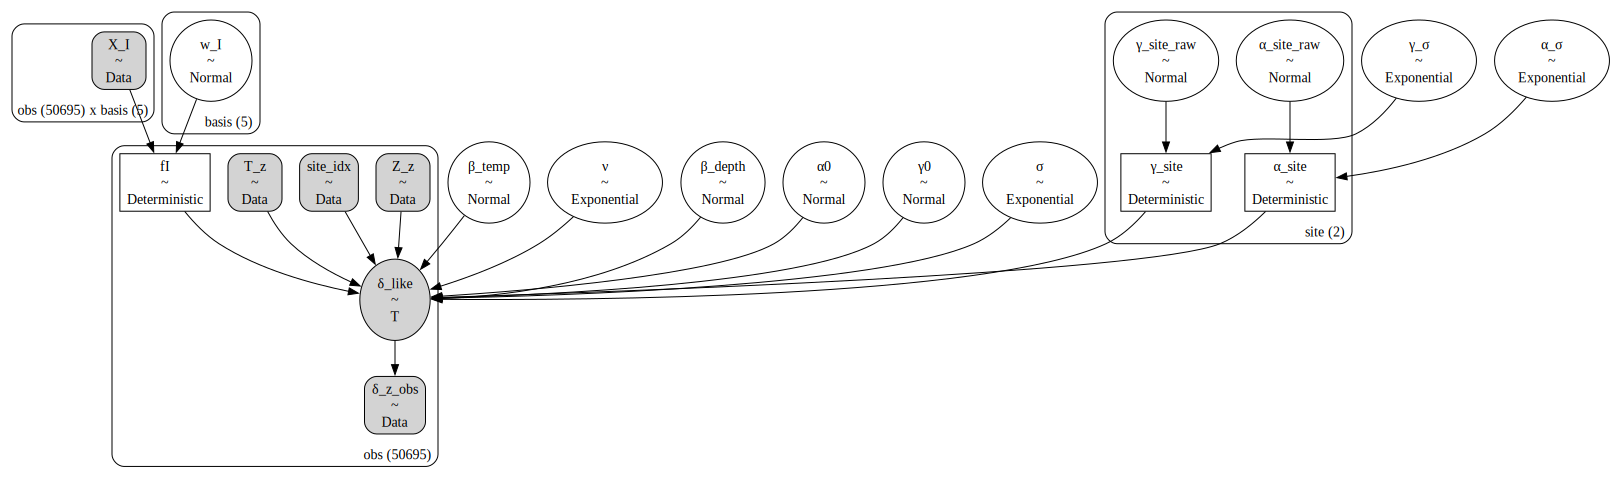

In [14]:
m_npq_hier_spline.to_graphviz()

***Fig. 2.*** **Bayesian Model Graph** This shows information flow through the model.

In [15]:
with m_npq_hier_spline:
    δ_pred = pm.StudentT("δ_pred", nu=ν, mu=μ, sigma=σ, dims="obs")

## Inference via variational approximation

Given the size of the dataset (≈50,000 observations) and the exploratory goal of this analysis, posterior inference is performed using automatic differentiation variational inference (ADVI).

ADVI provides a scalable approximation to the posterior distribution and is well suited for rapid iteration and model development. While variational methods can underestimate posterior uncertainty in some settings—particularly for hierarchical variance components—they are appropriate here for demonstrating model structure, uncertainty propagation, and posterior predictive behavior.

Full Markov chain Monte Carlo inference is left for future work.


In [17]:
# ADVI
with m_npq_hier_spline:
    approx = pm.fit(50_000, method="advi")
    trace_advi = approx.sample(2000)
    

Output()

Finished [100%]: Average Loss = 54,359


In [19]:
trace_advi.to_netcdf(ARTIFACTS_PATH / 'npq_hier_spline_trace_advi.nc')

PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/artifacts/npq_hier_spline_trace_advi.nc')

## Optimization diagnostics

Because ADVI does not produce Markov chains, traditional convergence diagnostics such as \hat{R} are not applicable. Instead, convergence is assessed by inspecting the optimization history of the variational objective.

A stable plateau in the loss trajectory is a necessary (though not sufficient) condition for a reliable variational approximation.


PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/figures/optim_history.png')

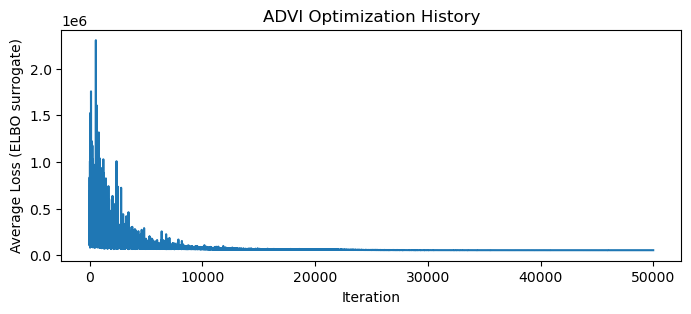

In [61]:
loss = approx.hist
import matplotlib.pyplot as pp
fig_optim_hist, ax = pp.subplots(figsize=(8, 3))
ax.plot(loss)
#fig = go.Figure()
#fig.add_trace(go.Scatter(y=loss, mode="lines", name="ADVI loss"))
#
ax.set_title("ADVI Optimization History")
ax.set_xlabel("Iteration")
ax.set_ylabel("Average Loss (ELBO surrogate)")
save_mpl(fig_optim_hist, "optim_history")

***Fig. 3.*** **ADVI optimization history for the hierarchical NPQ correction model.**  
The evolution of the average loss (an evidence lower bound–based objective) during automatic differentiation variational inference (ADVI) is shown across optimization iterations. The rapid initial decrease followed by a stable plateau indicates convergence of the variational approximation to a locally optimal posterior representation. While ADVI does not provide Markov chain–based convergence diagnostics, a stable loss trajectory is a necessary condition for reliable variational inference and supports the use of the resulting approximation for exploratory posterior analysis.


## Posterior summaries

Posterior summaries are reported only for structurally meaningful parameters, including:
- population-level effects,
- hierarchical variance components,
- site-level deviations,
- spline coefficients defining the irradiance response.

Per-observation latent quantities are not summarized directly, as their interpretation is best handled through posterior predictive checks and derived quantities.


In [19]:
key_vars = [
    "α0", "β_temp", "β_depth",
    "w_I", "γ0", "α_σ",
    "γ_σ", "σ", "ν", 
    "α_site","γ_site",
]

az.summary(trace_advi, var_names=key_vars, kind="stats")


,mean,sd,hdi_3%,hdi_97%
α0,0.341,0.002,0.337,0.346
β_temp,0.230,0.003,0.226,0.235
β_depth,-0.029,0.002,-0.033,-0.025
w_I[0],0.321,0.005,0.312,0.329
w_I[1],-0.261,0.011,-0.280,-0.241
w_I[2],-0.399,0.013,-0.425,-0.374
w_I[3],-1.243,0.016,-1.274,-1.213
w_I[4],-1.563,0.032,-1.619,-1.501
γ0,0.560,0.006,0.548,0.570
α_σ,0.157,0.004,0.150,0.163


In [23]:
#trace_advi = az.from_netcdf(ARTIFACTS_PATH / "npq_hier_spline_trace_advi.nc")

with m_npq_hier_spline:
    ppc_vi = pm.sample_posterior_predictive(trace_advi, var_names=["δ_like"], random_seed=42)

Sampling: [δ_like]


Output()

## Posterior predictive checks

Posterior predictive checks are used to evaluate whether the fitted model can reproduce key features of the observed data. Rather than relying solely on parameter summaries, we compare observed quantities to replicated datasets generated from the posterior predictive distribution.

These checks assess whether the model captures the distributional shape, tail behavior, and conditional structure of the NPQ correction.


PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/figures/rep_obs.png')

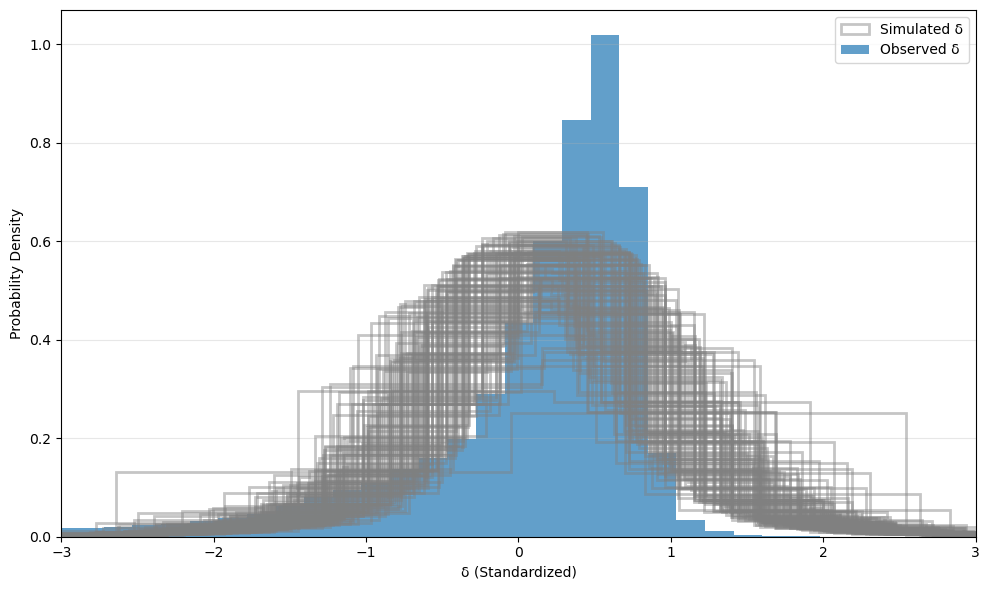

In [83]:
δ_obs = δ_z  # standardized observed δ (same vector used in pm.Data("δ_z_obs", ...))

δ_rep = ppc_vi.posterior_predictive["δ_like"].values
# Expected shapes: (chain, draw, obs) or (draw, obs)
if δ_rep.ndim == 3:
    δ_rep_flat = δ_rep.reshape(-1, δ_rep.shape[-1])
else:
    δ_rep_flat = δ_rep

# subsample replicated draws for plotting overlays
rng = np.random.default_rng(42)
n_show = min(100, δ_rep_flat.shape[0])
draw_idx = rng.choice(δ_rep_flat.shape[0], size=n_show, replace=False)
f_rep_obs = pp.figure(figsize=(10, 6))

# 1. Replicated distributions (thin overlays)
for i in draw_idx:
    label_text = "Simulated δ" if i == draw_idx[0] else None
    pp.hist(
        δ_rep_flat[i], 
        bins=50, 
        density=True, 
        color='gray', 
        alpha=0.45,  # Slightly higher than 0.01 as MPL rendering can be very faint
        histtype='step', # 'step' often looks cleaner for many overlays
        linewidth=2,
        label=label_text  # Matplotlib ignores 'None' labels in the legend
    )

# 2. Observed distribution
pp.hist(
    δ_obs, 
    bins=50, 
    density=True, 
    color='C0', 
    alpha=0.7, 
    label="Observed δ"
)

# Styling and Layout
pp.title("")
pp.xlabel("δ (Standardized)")
pp.ylabel("Probability Density")
pp.xlim(-3, 3)
pp.grid(axis='y', alpha=0.3)
pp.legend()

# Display
f_rep_obs.tight_layout()
save_mpl(f_rep_obs, "rep_obs")

***Fig. 5.*** **Posterior predictive check of the NPQ correction (δ): replicated versus observed distributions.**  
The distribution of observed standardized NPQ corrections (δ) is compared to replicated distributions generated from the posterior predictive distribution of the fitted hierarchical model. The black histogram shows the empirical distribution of δ, while the overlaid translucent histograms correspond to replicated draws from the posterior predictive distribution. Good agreement indicates that the model captures both the central tendency and tail behavior of the correction, including heavy-tailed variability modeled via a Student-t likelihood. Systematic discrepancies in location, spread, or tails would suggest model mis-specification or underestimation of uncertainty.


## Depth-resolved NPQ correction with uncertainty

To visualize how the inferred correction operates at the observation level, we compare observed fluorescence profiles to NPQ-corrected profiles as a function of depth for each site.

Uncertainty is shown via posterior credible intervals on the corrected fluorescence at each observation. To reduce overplotting while preserving vertical structure, one observation is randomly sampled per depth stratum at each rendering.

We will also start looking at site-specific NPQ results, not just population-level inference.

In [101]:
sites

['VP_AnthonysNose', 'VP_TeaIsland']

In [103]:
# Pick 2 stable colors from a Plotly qualitative palette
palette = px.colors.qualitative.D3  # nice, high-contrast
# Site-specific settings:
sites = list(model_coords["site"])
site_colors = {s: palette[i % len(palette)] for i, s in enumerate(sites)}
#site_labels = [k.split("_")[1] for k in sites]
site_labels = ["Anthony's Nose", "Tea Island"]

In [104]:
# ---------- Helper: sample 1 row per depth stratum ----------
def sample_one_per_depth(depth_arr, rng=None):
    """
    Returns indices that pick exactly 1 observation per unique depth value.
    If depth is quasi-continuous and produces too many unique values,
    replace unique depth with depth bins (see note below).
    """
    if rng is None:
        rng = np.random.default_rng()  # non-deterministic each run

    # group indices by exact depth value
    unique_depths = np.unique(depth_arr)

    chosen = []
    for d in unique_depths:
        idxs = np.where(depth_arr == d)[0]
        chosen.append(rng.choice(idxs))
    return np.array(chosen, dtype=int)

# ---------- Extract posterior predictive standardized δ_like for all obs ----------
δ_rep = ppc_vi.posterior_predictive["δ_like"].values
if δ_rep.ndim == 2:
    δ_rep = δ_rep[None, :, :]  # (chain, draw, obs)

# ---------- Get parameters to unstandardize δ and compute corrected fluorescence posterior ----------
δ_mu = scaler["Delta"]["mu"]
δ_sd = scaler["Delta"]["sd"]

sites = list(model_coords["site"])  # two sites

# ---------- Subplots: one row, two columns ----------
fig_npq_corr = make_subplots(
    rows=1, cols=2,
    subplot_titles=[f"Site: {s}" for s in site_labels],
    shared_yaxes=True,
    horizontal_spacing=0.08,
)

# Axis labels with units 
x_label = "Fluorescence (RFU)"
y_label = "Depth (m)"

rng = np.random.default_rng()  # no fixed seed => different sample each run

for j, site in enumerate(sites, start=1):
    c = site_colors[site]
    mask = (lake_george_df[col_site].astype(str) == str(site)).to_numpy()
    obs_idx = np.where(mask)[0]

    depth = lake_george_df.loc[mask, col_Z].to_numpy(float)
    F_obs = F[mask]

    # Slice δ posterior predictive to this site (keep obs alignment)
    δ_rep_site = δ_rep[:, :, obs_idx]  # (chain, draw, obs_site)

    # Unstandardize δ and compute corrected fluorescence posterior
    Delta_rep = δ_rep_site * δ_sd + δ_mu
    F_corr_rep = F_obs[None, None, :] + Delta_rep

    # Summaries: median + 94% equal-tailed interval (3%–97%)
    F_corr_med = np.median(F_corr_rep, axis=(0, 1))
    F_corr_lo  = np.quantile(F_corr_rep, 0.03, axis=(0, 1))
    F_corr_hi  = np.quantile(F_corr_rep, 0.97, axis=(0, 1))

    err_plus  = F_corr_hi - F_corr_med
    err_minus = F_corr_med - F_corr_lo

    # ---- sample 1 per depth stratum (exact depth values) ----
    sel_local = sample_one_per_depth(depth, rng=rng)
    # If needed, switch to binned strata:
    # sel_local = sample_one_per_depth_bin(depth, bin_size=0.5, rng=rng)

    # apply selection
    depth_s = depth[sel_local]
    F_obs_s = F_obs[sel_local]
    F_med_s = F_corr_med[sel_local]
    ep_s    = err_plus[sel_local]
    em_s    = err_minus[sel_local]

    # sort by depth for nicer layering
    order = np.argsort(depth_s)
    depth_s = depth_s[order]
    F_obs_s = F_obs_s[order]
    F_med_s = F_med_s[order]
    ep_s    = ep_s[order]
    em_s    = em_s[order]

    # Observed: black triangles, larger, higher opacity
    fig_npq_corr.add_trace(
        go.Scatter(
            x=F_obs_s,
            y=depth_s,
            mode="markers",
            name="Observed F" if j == 1 else None,  # show legend once
            showlegend=(j == 1),
            marker=dict(symbol="triangle-right", color="black", size=9, opacity=0.70),
            hovertemplate="Depth: %{y:.2f} m<br>Observed F: %{x:.4g}<extra></extra>",
        ),
        row=1, col=j
    )

    # Corrected: smaller circles with 94% CrI error bars, lower opacity
    fig_npq_corr.add_trace(
        go.Scatter(
            x=F_med_s,
            y=depth_s,
            mode="markers",
            name="Corrected F (median ± 94% CrI)" if j == 1 else None,
            showlegend=(j == 1),
            marker=dict(symbol="circle", size=6, opacity=0.35, color=c),
            error_x=dict(
                type="data",
                symmetric=False,
                array=ep_s,
                arrayminus=em_s,
                thickness=1.0,
                width=0,
            ),
            hovertemplate="Depth: %{y:.2f} m<br>Corrected F (median): %{x:.4g}<extra></extra>",
        ),
        row=1, col=j
    )

# Layout + axes
fig_npq_corr.update_layout(
    title="",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.08, xanchor="left", x=0.0),
)

# Depth increases downward (apply to y-axis; shared y)
fig_npq_corr.update_yaxes(autorange="reversed", title_text=y_label, row=1, col=1)
fig_npq_corr.update_yaxes(autorange="reversed", row=1, col=2)

# X-axis labels with units
fig_npq_corr.update_xaxes(title_text=x_label, row=1, col=1)
fig_npq_corr.update_xaxes(title_text=x_label, row=1, col=2)
save_plotly_html(fig_npq_corr, "npq_corr")
fig_npq_corr.show()


***Fig. 6.*** **Depth-resolved NPQ correction for two sites, with posterior uncertainty.**  
Observed fluorescence measurements (black triangles) and NPQ-corrected fluorescence (circles) are shown as a function of depth for each site. Corrected values represent posterior medians from the hierarchical Bayesian model, with horizontal error bars indicating 94% posterior credible intervals for the corrected fluorescence at each observation. To reduce overplotting while preserving vertical structure, one observation is randomly sampled per depth stratum at each rendering, ensuring that all sampled depth levels are represented. Depth is plotted increasing downward following oceanographic convention. Differences between sites reflect partial pooling in the hierarchical model, which allows site-specific modulation of the shared NPQ–irradiance response while borrowing strength across sites.


## Learned NPQ–irradiance response

The fitted model implies a smooth population-level relationship between subsurface irradiance and the NPQ correction. This relationship is represented by a spline-based latent function and is inferred jointly with all other model components.

Visualizing this function and its posterior uncertainty provides insight into how strongly the data constrain the mean NPQ response to light, independently of observation-level noise.


In [ ]:
# 1) Build irradiance grid in original units
I_sub = lake_george_df[col_I].to_numpy(float)
I_sub = np.clip(I_sub, 0.0, None)

I_min = float(np.quantile(I_sub, 0.01))
I_max = float(np.quantile(I_sub, 0.99))

I_grid = np.linspace(I_min, I_max, 200)

# 2) Apply the exact same transform + standardization as in the model
I_log_grid = np.log1p(I_grid)

I_mu = scaler["I_log"]["mu"]
I_sd = scaler["I_log"]["sd"]
I_z_grid = (I_log_grid - I_mu) / I_sd

# 3) Rebuild spline basis on the grid using the same formula you used for X_I
# IMPORTANT: must match: bs(I_z, df=4, degree=3, include_intercept=False)
X_grid = dmatrix(
    "bs(I_z, df=4, degree=3, include_intercept=False)",
    {"I_z": I_z_grid},
    return_type="dataframe",
).to_numpy()  # (n_grid, n_basis)

# 4) Get posterior draws of w_I
w = trace_advi.posterior["w_I"].values  # (chain, draw, basis)
w_flat = w.reshape(-1, w.shape[-1])   # (S, basis)

# 5) Compute f(I) for each posterior draw
# f_grid = X_grid @ w.T -> (n_grid, S), transpose to (S, n_grid)
f_grid = (X_grid @ w_flat.T).T

# 6) Summarize with 94% interval
f_med = np.median(f_grid, axis=0)
f_lo  = np.quantile(f_grid, 0.03, axis=0)
f_hi  = np.quantile(f_grid, 0.97, axis=0)

# 7) Plot (use irradiance in original units on x-axis)
fig = go.Figure()

# credible band
fig.add_trace(go.Scatter(
    x=np.concatenate([I_grid, I_grid[::-1]]),
    y=np.concatenate([f_hi, f_lo[::-1]]),
    fill="toself",
    line=dict(width=0),
    opacity=0.50,
    name="94% credible band",
    hoverinfo="skip",
))

# median curve
fig.add_trace(go.Scatter(
    x=I_grid,
    y=f_med,
    mode="lines",
    name="Median f(I)",
    color='black'
))

fig.update_layout(
    title="",
    xaxis_title="Subsurface irradiance (W m⁻²)",
    yaxis_title="f(I) (standardized δ units)",
    template="plotly_white",
)

fig.show()
save_plotly_html(fig, "lake_george_npq_irradiance_response")

PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/figures/lake_george_npq_irradiance_response.html')

***Fig. 7.*** **Population-level NPQ–irradiance response from the hierarchical Bayesian model.**  
The population-level relationship between subsurface irradiance and the NPQ correction is shown as a smooth function learned by a cubic B-spline on log-transformed irradiance. The solid line represents the posterior median of the latent irradiance response f(I), while the shaded region denotes the 94% posterior credible interval for this latent function. The credible band is relatively narrow compared to the uncertainty in posterior predictive replicates because this figure reflects uncertainty in the inferred *mean NPQ–irradiance relationship* alone, not observation-level variability. In particular, it excludes the Student-t observation noise and site-level stochasticity that contribute to the wider predictive intervals for individual corrections. As a result, this figure highlights how well the data constrain the shared functional form of the NPQ response to light, rather than the uncertainty associated with predicting individual fluorescence observations.


In [ ]:
# ---- pull posterior pieces ----
idata = trace_advi  # or whatever you named it

wI_da = stack_sample(idata.posterior["w_I"])
basis_dim = [d for d in wI_da.dims if d != "sample"][0]
w_I = wI_da.transpose("sample", basis_dim).values  # (S, K)

γ0 = stack_sample(idata.posterior["γ0"]).values  # (S,)

αs = stack_sample(idata.posterior["α_site"]).transpose("sample", "site").values  # (S, n_site)
γs = stack_sample(idata.posterior["γ_site"]).transpose("sample", "site").values  # (S, n_site)

# ---- compute fI(I_grid) per draw: (S, n_grid) ----
fI_grid = w_I @ X_grid.T  # (S, n_grid)

# ---- NPQ curve in standardized delta space, holding depth/temp at 0 ----
# delta_curve(site) = α_site + (γ0 + γ_site) * fI(I)
delta_curve = αs[:, :, None] + (γ0[:, None, None] + γs[:, :, None]) * fI_grid[:, None, :]  # (S, n_site, n_grid)

# If you want it unstandardized to match Delta units used elsewhere:
δ_mu = scaler["Delta"]["mu"]
δ_sd = scaler["Delta"]["sd"]
Delta_curve = delta_curve * δ_sd + δ_mu  # (S, n_site, n_grid)

# ---- summarize per site across draws ----
fig = go.Figure()

for j, site in enumerate(sites):
    # pick which curve you want to show: standardized or unstandardized
    curve = Delta_curve[:, j, :]  # (S, n_grid)

    lo, med, hi = q_summary(curve, axis=0)

    c = site_colors[site]
    fill = rgba(c, 0.20)

    # ribbon: add upper then lower reversed
    fig.add_trace(
        go.Scatter(
            x=I_grid,
            y=hi,
            mode="lines",
            line=dict(color="rgba(0,0,0,0)"),
            showlegend=False,
            hoverinfo="skip",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=I_grid,
            y=lo,
            mode="lines",
            line=dict(color="rgba(0,0,0,0)"),
            fill="tonexty",
            fillcolor=fill,
            showlegend=False,
            hoverinfo="skip",
        )
    )

    # median line
    fig.add_trace(
        go.Scatter(
            x=I_grid,
            y=med,
            mode="lines",
            name=f"{site}",
            line=dict(color=c, width=3),
            hovertemplate="I: %{x:.4g}<br>δ (median): %{y:.4g}<extra></extra>",
        )
    )

fig.update_layout(
    template="plotly_white",
    title="",
    legend=dict(orientation="h", yanchor="bottom", y=1.08, xanchor="left", x=0.0),
)

fig.update_xaxes(title_text="Subsurface irradiance (W m⁻²)")
fig.update_yaxes(title_text="Modeled NPQ correction curve, δ")

save_plotly_html(fig, "npq_curve_by_site_singlepanel")
fig.show()


## Limitations and future directions

This analysis is intentionally limited in scope. Key limitations include:
- reliance on ADVI rather than full MCMC, which may underestimate uncertainty in some parameters,
- only two sites, limiting the depth of hierarchical structure,
- no explicit modeling of diel time dependence,
- subsurface irradiance treated as known, without optical uncertainty.

Future work could extend this framework to additional lakes, incorporate time explicitly, and perform full MCMC inference to support formal model comparison.


## In Conclusion...

This notebook demonstrates how Bayesian hierarchical modeling can be used to represent NPQ correction as a generative process with explicit uncertainty and partial pooling across sites. While exploratory, the approach highlights several advantages over point-estimate correction schemes.

The modeling framework presented here is intended as a starting point for further development and collaboration, particularly in settings where uncertainty quantification and cross-site generalization are important.


In [105]:
import re
import numpy as np
import plotly.graph_objects as go

def clean_site_name(name: str) -> str:
    """Removes VP_ prefix, splits CamelCase, and adds apostrophes."""
    name = name.removeprefix("VP_")
    name = re.sub(r'([a-z])([A-Z])', r'\1 \2', name)
    return name.replace("Anthonys", "Anthony's")

def add_ribbon_trace(fig, x, lo, hi, color, name, show_legend=False):
    """Adds an uncertainty ribbon using the 'tonexty' method."""
    # Upper bound (invisible)
    fig.add_trace(go.Scatter(
        x=x, y=hi, mode="lines", line=dict(color="rgba(0,0,0,0)"),
        showlegend=False, hoverinfo="skip"
    ))
    # Lower bound + Fill
    fig.add_trace(go.Scatter(
        x=x, y=lo, mode="lines", line=dict(color="rgba(0,0,0,0)"),
        fill="tonexty", fillcolor=rgba(color, 0.2),
        showlegend=show_legend, name=f"{name} (94% CI)", hoverinfo="skip"
    ))

def rgba(hex_color: str, alpha: float) -> str:
    hex_color = hex_color.lstrip("#")
    r, g, b = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]
    return f"rgba({r},{g},{b},{alpha})"

In [120]:
def compute_pop_delta(idata, X_grid, scaler, include_global_intercept=False):
    # Get Spline weights and global slope gamma0
    w_flat = stack_sample(idata.posterior["w_I"]).values.transpose() # (S, basis)
    γ0 = stack_sample(idata.posterior["γ0"]).values # (S,)
    
    # Calculate standardized population curve: gamma0 * f(I)
    # Note: We assume population intercept is 0 in standardized space
    f_grid = (X_grid @ w_flat.T).T 
    pop_δ = γ0[:, None] * f_grid 
    if include_global_intercept:
        α_0 = stack_sample(idata.posterior["α_0"]).values # (S,)
        pop_δ += α_0[:, None]

    # Unstandardize to match site units
    return pop_δ * scaler["Delta"]["sd"] + scaler["Delta"]["mu"]
    

def compute_site_delta(idata, X_grid, scaler):
    w_I = stack_sample(idata.posterior["w_I"]).transpose("sample", ...).values
    γ0 = stack_sample(idata.posterior["γ0"]).values
    αs = stack_sample(idata.posterior["α_site"]).transpose("sample", "site").values
    γs = stack_sample(idata.posterior["γ_site"]).transpose("sample", "site").values
    
    fI_grid = w_I @ X_grid.T 
    # delta = alpha + (gamma0 + gamma_site) * f(I)
    δ_sites = αs[:, :, None] + (γ0[:, None, None] + γs[:, :, None]) * fI_grid[:, None, :]
    return δ_sites * scaler["Delta"]["sd"] + scaler["Delta"]["mu"]

In [121]:
def plot_npq_curves(
    idata, X_grid, I_grid, scaler, sites_raw,
    include_pop=True, 
    include_sites=True,
    include_global_intercept=False,
    pop_color="#000000"
):
    fig = go.Figure()
    
    # 1. Population Logic (Now Unstandardized)
    if include_pop:
        pop_Δ = compute_pop_delta(idata, X_grid, scaler, include_global_intercept)
        lo, med, hi = q_summary(pop_Δ, axis=0)
        
        add_ribbon_trace(fig, I_grid, lo, hi, pop_color, "Population")
        fig.add_trace(go.Scatter(
            x=I_grid, y=med, mode="lines", name="Population (Global)",
            line=dict(color=pop_color, width=4, dash='dash') # Dashed to stand out
        ))

    # 2. Site-Specific Logic (Unstandardized)
    if include_sites:
        sites_clean = [clean_site_name(s) for s in sites_raw]
        palette = px.colors.qualitative.D3
        
        
        Δ_curve = compute_site_delta(idata, X_grid, scaler)
        for j, site in enumerate(sites_clean):
            curve = Δ_curve[:, j, :]
            lo, med, hi = q_summary(curve, axis=0)
            
            c = palette[j % len(palette)]
            add_ribbon_trace(fig, I_grid, lo, hi, c, site)
            fig.add_trace(go.Scatter(
                x=I_grid, y=med, mode="lines", name=site,
                line=dict(color=c, width=2)
            ))

    fig.update_layout(
        template="plotly_white",
        xaxis_title="Subsurface irradiance (W m⁻²)",
        yaxis_title="NPQ Correction (δ) [Original Units]",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
    )
    return fig

[]

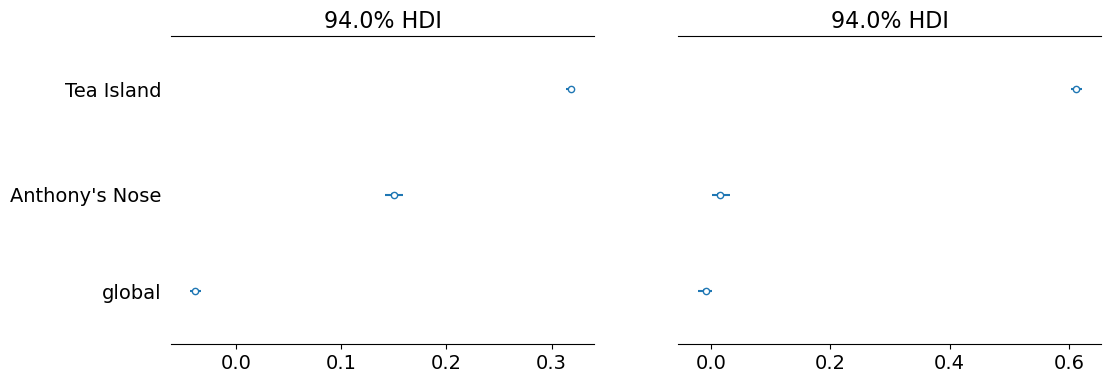

In [134]:
f, axes = pp.subplots(1, 2, figsize=(12, 4), sharey=True)
ylabels = ['global', "Anthony's Nose", "Tea Island"]
ax = az.plot_forest(trace_advi, var_names=["α0", "α_site"], ax=axes[0])
ax = az.plot_forest(trace_advi, var_names=["γ0", "γ_site"], ax=axes[1])
axes[0].set_yticklabels(ylabels)
axes[1].set_yticklabels(ylabels)
#f.tight_layout()

In [136]:
fig_complete = plot_npq_curves(trace_advi, X_grid, I_grid, scaler, model_coords["site"], pop_color="#000000")
fig_complete.show()
save_plotly_html(fig_complete, "npq_curves.html")

PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/figures/npq_curves_html.html')

In [ ]:
# ---------- 1) Posterior extraction ----------
def extract_posterior_terms(idata):
    """
    Return a dict of flattened posterior draws for terms used in mu.
    Assumes stack_sample() is available.
    """
    out = {}
    out["alpha0"] = stack_sample(idata.posterior["α0"]).values              # (S,)
    out["betaT"]  = stack_sample(idata.posterior["β_temp"]).values         # (S,)
    out["betaZ"]  = stack_sample(idata.posterior["β_depth"]).values        # (S,)
    out["gamma0"] = stack_sample(idata.posterior["γ0"]).values             # (S,)

    out["alpha_site"] = stack_sample(idata.posterior["α_site"])\
        .transpose("sample", "site").values                                # (S, n_site)

    out["gamma_site"] = stack_sample(idata.posterior["γ_site"])\
        .transpose("sample", "site").values                                # (S, n_site)

    # w_I: (S, K)
    w_da = stack_sample(idata.posterior["w_I"])
    basis_dim = [d for d in w_da.dims if d != "sample"][0]
    out["w_I"] = w_da.transpose("sample", basis_dim).values                # (S, K)

    return out


# ---------- 2) Spline response on grid ----------
def compute_f_grid(w_I, X_grid):
    """
    f_grid = w_I @ X_grid.T
    w_I: (S, K)
    X_grid: (n_grid, K)
    returns: (S, n_grid)
    """
    return w_I @ X_grid.T


# ---------- 3) Conditional mu curves (Z=T=0) ----------
def mu_pop_curve(f_grid, alpha0, gamma0):
    """
    mu_pop(I) = alpha0 + gamma0 * f(I)
    returns: (S, n_grid)
    """
    return alpha0[:, None] + gamma0[:, None] * f_grid


def mu_site_curves(f_grid, alpha0, gamma0, alpha_site, gamma_site):
    """
    mu_site(I,s) = alpha0 + alpha_site[s] + (gamma0 + gamma_site[s]) * f(I)
    returns: (S, n_site, n_grid)
    """
    return (
        alpha0[:, None, None]
        + alpha_site[:, :, None]
        + (gamma0[:, None, None] + gamma_site[:, :, None]) * f_grid[:, None, :]
    )


# ---------- 4) Per-observation mu (this is the "composition" engine) ----------
def mu_per_observation(
    fI_obs, site_idx, T_z, Z_z,
    alpha0, gamma0, alpha_site, gamma_site, betaT, betaZ,
    include_T=True, include_Z=True
):
    """
    Computes mu for each posterior draw and each observation i.

    fI_obs: (S, n_obs)  -- should correspond to fI in the model at each obs (already uses X_I at obs)
    site_idx: (n_obs,) integer site index
    T_z, Z_z: (n_obs,) standardized covariates
    returns: (S, n_obs)
    """
    a_site = alpha_site[:, site_idx]               # (S, n_obs)
    g_site = gamma_site[:, site_idx]               # (S, n_obs)

    mu = alpha0[:, None] + a_site + (gamma0[:, None] + g_site) * fI_obs

    if include_T:
        mu = mu + betaT[:, None] * T_z[None, :]
    if include_Z:
        mu = mu + betaZ[:, None] * Z_z[None, :]

    return mu


# ---------- 5) Aggregate (bin) by irradiance ----------
def binned_summary(x, vals, n_bins=20, q=(0.03, 0.5, 0.97)):
    """
    x: (n_obs,) e.g. I_sub
    vals: (S, n_obs) e.g. mu per observation
    Returns bin centers and quantiles over flattened draws*obs in each bin.
    """
    x = np.asarray(x)
    bins = np.quantile(x, np.linspace(0, 1, n_bins + 1))
    bin_id = np.digitize(x, bins[1:-1], right=True)
    nb = bin_id.max() + 1

    x_bin = np.array([np.median(x[bin_id == b]) for b in range(nb)])

    lo = np.empty(nb); med = np.empty(nb); hi = np.empty(nb)
    for b in range(nb):
        v = vals[:, bin_id == b].reshape(-1)
        lo[b], med[b], hi[b] = np.quantile(v, q)

    return x_bin, lo, med, hi


In [ ]:
terms = extract_posterior_terms(trace_advi)

# fI_obs from posterior deterministic (best for per-observation mu)
fI_obs = stack_sample(trace_advi.posterior["fI"]).transpose("sample", "obs").values  # (S, n_obs)

# Full mix
mu_full = mu_per_observation(
    fI_obs=fI_obs, site_idx=site_idx, T_z=T_z, Z_z=Z_z,
    alpha0=terms["alpha0"], gamma0=terms["gamma0"],
    alpha_site=terms["alpha_site"], gamma_site=terms["gamma_site"],
    betaT=terms["betaT"], betaZ=terms["betaZ"],
    include_T=True, include_Z=True
)

# No-temp mix (temperature contribution removed, composition otherwise identical)
mu_noT = mu_per_observation(
    fI_obs=fI_obs, site_idx=site_idx, T_z=T_z, Z_z=Z_z,
    alpha0=terms["alpha0"], gamma0=terms["gamma0"],
    alpha_site=terms["alpha_site"], gamma_site=terms["gamma_site"],
    betaT=terms["betaT"], betaZ=terms["betaZ"],
    include_T=False, include_Z=True
)


mu_noZ = mu_per_observation(
    fI_obs=fI_obs, site_idx=site_idx, T_z=T_z, Z_z=Z_z,
    alpha0=terms["alpha0"], gamma0=terms["gamma0"],
    alpha_site=terms["alpha_site"], gamma_site=terms["gamma_site"],
    betaT=terms["betaT"], betaZ=terms["betaZ"],
    include_T=True, include_Z=False
)

# Bin both by I_sub
x_bin, lo_f, med_f, hi_f, nbin = binned_summary(I_sub, mu_full, n_bins=20)
_,     lo_t, med_t, hi_t, _ = binned_summary(I_sub, mu_noT, n_bins=20)
_,     lo_z, med_z, hi_z, _ = binned_summary(I_sub, mu_noZ, n_bins=20)

# Temperature "effect" under observed composition:
# temp_effect_med = med_f - med_t


In [ ]:
# ---- helpers ----
def binned_summary(x, vals, n_bins=20, q=(0.03, 0.5, 0.97)):
    """
    x: (n_obs,)
    vals: (S, n_obs)
    Quantiles computed over all posterior draws + observations within each bin.
    """
    x = np.asarray(x)
    bins = np.quantile(x, np.linspace(0, 1, n_bins + 1))
    bin_id = np.digitize(x, bins[1:-1], right=True)
    nb = int(bin_id.max() + 1)

    x_bin = np.array([np.median(x[bin_id == b]) for b in range(nb)])
    n_in_bin = np.array([(bin_id == b).sum() for b in range(nb)])

    lo = np.empty(nb); med = np.empty(nb); hi = np.empty(nb)
    for b in range(nb):
        v = vals[:, bin_id == b].reshape(-1)
        lo[b], med[b], hi[b] = np.quantile(v, q)

    return x_bin, lo, med, hi, n_in_bin

def ribbon(fig, x, lo, hi, name, color, row, col, showlegend=True, opacity=0.18):
    fig.add_trace(
        go.Scatter(
            x=x, y=hi, mode="lines", line=dict(width=0),
            showlegend=False, hoverinfo="skip",
        ),
        row=row, col=col
    )
    fig.add_trace(
        go.Scatter(
            x=x, y=lo, mode="lines", fill="tonexty",
            fillcolor=f"rgba{tuple(int(color[i:i+2], 16) for i in (1,3,5)) + (opacity,)}"
                      if color.startswith("#") else color,
            line=dict(width=0),
            name=name + " (94% band)" if showlegend else None,
            showlegend=showlegend,
            hoverinfo="skip",
        ),
        row=row, col=col
    )

def line(fig, x, y, name, color, row, col, dash="solid", showlegend=True, extra_hover=None):
    hover = "I: %{x:.3g}<br>μ: %{y:.4g}"
    if extra_hover is not None:
        hover += "<br>" + extra_hover
    hover += "<extra></extra>"
    fig.add_trace(
        go.Scatter(
            x=x, y=y, mode="lines",
            name=name, showlegend=showlegend,
            line=dict(color=color, width=3, dash=dash),
            hovertemplate=hover,
        ),
        row=row, col=col
    )

# ---- expected inputs already computed by you ----
# I_sub: (n_obs,) subsurface irradiance in original units
# mu_full: (S, n_obs) computed with include_T=True, include_Z=True
# mu_noT:  (S, n_obs) computed with include_T=False, include_Z=True

# ---- bin summaries ----
#x_bin, lo_f, med_f, hi_f, nbin = binned_summary(I_sub, mu_full, n_bins=20)
#_,     lo_t, med_t, hi_t, _    = binned_summary(I_sub, mu_noT,  n_bins=20)

# Difference (temperature contribution under observed composition)
diff = med_f - med_t

# ---- plot ----
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        "Binned μ(I): full mix vs no-temperature",
        "Implied temperature contribution: (full − no-temp)"
    ],
    horizontal_spacing=0.10
)

c_full = "#1f77b4"   # blue
c_not  = "#7f7f7f"   # gray

# left panel: ribbons + medians
ribbon(fig, x_bin, lo_f, hi_f, "Full mix", c_full, row=1, col=1, showlegend=True, opacity=0.16)
line(fig,   x_bin, med_f,       "Full mix (median)", c_full, row=1, col=1, dash="solid", showlegend=True,
     extra_hover="n_bin: %{customdata}")

ribbon(fig, x_bin, lo_t, hi_t, "No-temp", c_not, row=1, col=1, showlegend=True, opacity=0.10)
line(fig,   x_bin, med_t,       "No-temp (median)", c_not, row=1, col=1, dash="dash", showlegend=True,
     extra_hover="n_bin: %{customdata}")

# Attach n_bin via customdata to both lines (for hover)
fig.data[-3].customdata = nbin  # full line (median)
fig.data[-1].customdata = nbin  # no-temp line (median)

# right panel: diff line
fig.add_trace(
    go.Scatter(
        x=x_bin, y=diff, mode="lines",
        name="Temp contribution (median)",
        line=dict(width=3),
        hovertemplate="I: %{x:.3g}<br>Δμ_temp: %{y:.4g}<extra></extra>",
        showlegend=True
    ),
    row=1, col=2
)
# zero reference
fig.add_hline(y=0, line_width=1, line_dash="dot", row=1, col=2)

fig.update_layout(
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="left", x=0),
    margin=dict(l=50, r=30, t=70, b=50),
)
fig.update_xaxes(title_text="Subsurface irradiance (W m⁻²)", row=1, col=1)
fig.update_xaxes(title_text="Subsurface irradiance (W m⁻²)", row=1, col=2)
fig.update_yaxes(title_text="μ (standardized δ space)", row=1, col=1)
fig.update_yaxes(title_text="Δμ due to temperature", row=1, col=2)

fig.show()

In [ ]:
save_plotly_html(fig, "mu_mix_temp")

PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/figures/mu_mix_temp.html')

In [ ]:
# Difference (depth contribution under observed composition)
diff_z = med_f - med_z

# ---- plot ----
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        "Binned μ(I): full mix vs no-depth",
        "Implied depth contribution: (full − no-depth)"
    ],
    horizontal_spacing=0.10
)

c_full = "#1f77b4"   # blue
c_not  = "#7f7f7f"   # gray

# left panel: ribbons + medians
ribbon(fig, x_bin, lo_f, hi_f, "Full mix", c_full, row=1, col=1, showlegend=True, opacity=0.16)
line(fig,   x_bin, med_f,       "Full mix (median)", c_full, row=1, col=1, dash="solid", showlegend=True,
     extra_hover="n_bin: %{customdata}")

ribbon(fig, x_bin, lo_z, hi_z, "No-depth", c_not, row=1, col=1, showlegend=True, opacity=0.10)
line(fig,   x_bin, med_z,       "No-depth (median)", c_not, row=1, col=1, dash="dash", showlegend=True,
     extra_hover="n_bin: %{customdata}")

# Attach n_bin via customdata to both lines (for hover)
fig.data[-3].customdata = nbin  # full line (median)
fig.data[-1].customdata = nbin  # no-depth line (median)

# right panel: diff line
fig.add_trace(
    go.Scatter(
        x=x_bin, y=diff_z, mode="lines",
        name="Depth contribution (median)",
        line=dict(width=3),
        hovertemplate="I: %{x:.3g}<br>Δμ_depth: %{y:.4g}<extra></extra>",
        showlegend=True
    ),
    row=1, col=2
)
# zero reference
fig.add_hline(y=0, line_width=1, line_dash="dot", row=1, col=2)

fig.update_layout(
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="left", x=0),
    margin=dict(l=50, r=30, t=70, b=50),
)
fig.update_xaxes(title_text="Subsurface irradiance (W m⁻²)", row=1, col=1)
fig.update_xaxes(title_text="Subsurface irradiance (W m⁻²)", row=1, col=2)
fig.update_yaxes(title_text="μ (standardized δ space)", row=1, col=1)
fig.update_yaxes(title_text="Δμ due to depth", row=1, col=2)

fig.show()
save_plotly_html(fig, "mu_mix_depth")

PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/figures/mu_mix_depth.html')